In [4]:
import tensorflow as tf
from tensorflow.keras import layers

In [5]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
EMBEDDING_DIM = 200
#top_dropout_rate = 0.2

In [6]:
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
# https://www.kaggle.com/chienhsianghung/shopee-text-img-embedding-colab-enabled

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs,
    pooling="avg"
#    drop_connect_rate=0.4 # 0.2 is default
)
model.trainable = False
#x = layers.BatchNormalization()(model.output)
#x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = model(inputs) #layers.Dense(EMBEDDING_DIM, name="pred")(x)
model = tf.keras.Model(inputs, outputs, name="EfficientNet")

In [7]:
model.summary()

Model: "EfficientNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
_________________________________________________________________


In [8]:
import os
import random
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [229]:
release = '34014'

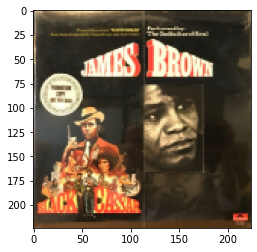

In [251]:
img = cv.imread(f'popsike/{release}_cropped.png', cv.IMREAD_COLOR)
img = cv.resize(img, (IMG_SIZE, IMG_SIZE), interpolation = cv.INTER_AREA)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
fig = plt.figure()
fig.add_subplot().imshow(img)
plt.show()

In [252]:
test_vector = model.predict(np.array([img]))

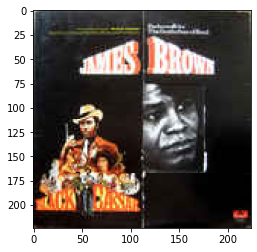

In [253]:
img = cv.imread('thumbs/thumb_' + release + '.jpg', cv.IMREAD_COLOR)
img = cv.resize(img, (IMG_SIZE, IMG_SIZE), interpolation = cv.INTER_AREA)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
fig = plt.figure()
fig.add_subplot().imshow(img)
plt.show()

In [254]:
ground_truth_vector = model.predict(np.array([img]))

In [255]:
np.linalg.norm(ground_truth_vector[0] - test_vector[0])

9.84292

### Precompute image vectors

In [102]:
from tqdm.notebook import tqdm

In [259]:
batch_size = 256
image_vectors = {}

In [260]:
releases = [_[6:-4] for _ in os.listdir('thumbs') if _[6:-4].isnumeric()]

In [261]:
for i in tqdm(range(0, len(releases), batch_size)):
    batch = []
    for j in range(0, min(batch_size, len(releases) - i)):
        img = cv.imread('thumbs/thumb_' + releases[i + j] + '.jpg', cv.IMREAD_COLOR)
        img = cv.resize(img, (IMG_SIZE, IMG_SIZE), interpolation = cv.INTER_AREA)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        batch += [img]
    vectors = model.predict(np.array(batch))
    for j in range(0, min(batch_size, len(releases) - i)):
        image_vectors[releases[i + j]] = vectors[j]

  0%|          | 0/3997 [00:00<?, ?it/s]

In [262]:
import pickle
pickle.dump(image_vectors, open('image_vectors.p', 'wb'))

### Baseline model

In [263]:
distances = [(np.linalg.norm(image_vectors[_] - test_vector[0]), _) for _ in image_vectors]

In [264]:
distances.sort()

9.842921 34014


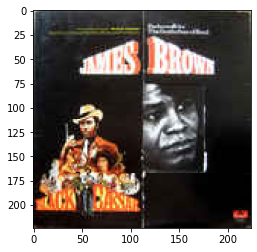

11.11848 1010058


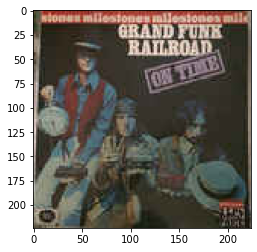

11.30015 138359


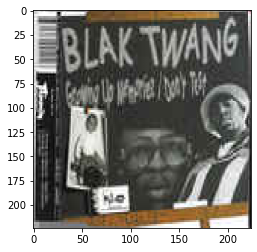

11.329363 1056417


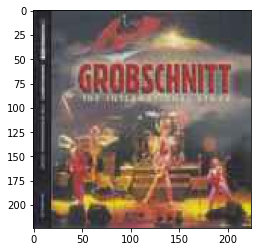

11.348825 1431183


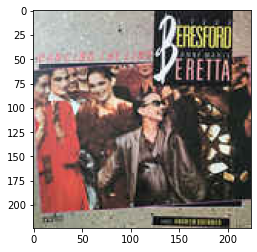

In [265]:
for _ in distances[:5]:
    print(_[0], _[1])
    img = cv.imread('thumbs/thumb_' + _[1] + '.jpg', cv.IMREAD_COLOR)
    img = cv.resize(img, (IMG_SIZE, IMG_SIZE), interpolation = cv.INTER_AREA)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    fig = plt.figure()
    fig.add_subplot().imshow(img)
    plt.show()

In [ ]:
# rescale /128 - 1.0 ?
# maybe not use opencv to read images...